# 🤖**Transformer Chatbot practice & learning**

**글쓴이 : 이영노**

**날짜 : 2023/02/21**

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
from collections import Counter
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.utils.data
import math
import torch.nn.functional as F

In [17]:
corpus_movie_conv = '/content/drive/MyDrive/23SS_NLP/5/movie_conversations.txt'
corpus_movie_lines = '/content/drive/MyDrive/23SS_NLP/5/movie_lines.txt'
max_len = 25

In [18]:
with open(corpus_movie_conv, 'r') as c:
  conv = c.readlines()

with open(corpus_movie_lines, 'r', encoding='unicode_escape')as l:
  lines = l.readlines()

In [19]:
# 대사넘버 : 발화문 형태의 dictionary로 변환
lines_dic = {}
for line in lines:
  objects = line.split(" +++$+++ ")
  lines_dic[objects[0]] = objects[-1]

### 전처리 자세한 과정과 반환값

In [20]:
lines[-1]

"L666256 +++$+++ u9034 +++$+++ m616 +++$+++ VEREKER +++$+++ Colonel Durnford... William Vereker. I hear you 've been seeking Officers?\n"

In [21]:
lines[-1].split(" +++$+++ ")

['L666256',
 'u9034',
 'm616',
 'VEREKER',
 "Colonel Durnford... William Vereker. I hear you 've been seeking Officers?\n"]

In [22]:
dic = {}
dic['name'] = 'value'
print(dic)

{'name': 'value'}


In [23]:
dic = {}
dic[lines[-1].split("+++$+++")[0]] = lines[-1].split("+++$+++")[-1]
dic

{'L666256 ': " Colonel Durnford... William Vereker. I hear you 've been seeking Officers?\n"}

### 다시 돌아와서

In [24]:
# 구두점, 특수문자 제거
def remove_punc(string):
  punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
  no_punct = ""
  for char in string:
    if char not in punctuations:
      no_punct = no_punct + char
  return no_punct.lower()

⭐ 문장을 단어로 쪼개서 pair로 묶는 것에 집중

In [25]:
pairs = []
for con in conv: 
  ids = eval(con.split(" +++$+++")[-1]) 
  for i in range(len(ids)):
    qa_pairs = []

    if i == len(ids)-1:
      break
    
    first = remove_punc(lines_dic[ids[i]].strip())
    second = remove_punc(lines_dic[ids[i+1]].strip())
    qa_pairs.append(first.split()[:max_len]) # 단어로 만들어주고, max_len만큼 인덱싱함
    qa_pairs.append(second.split()[:max_len])
    pairs.append(qa_pairs) # QA를 단어로 쪼갠 뒤 pair로 만든것의 전체 pairs


### 전처리 자세한 과정과 반환값

In [26]:
conv[0]

"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']\n"

In [27]:
ids_ex = eval(conv[0].split(" +++$+++ ")[-1]) # ids # eval함수 써서 \n 제거해줌
print(ids_ex)

['L194', 'L195', 'L196', 'L197']


In [28]:
print(lines_dic[ids_ex[0]].strip())
# 이것은 곧, 아까만든 대화넘버 : 발화문 dict의 key이므로,
# dict에다가 key로 인덱싱 하면 input 대화넘버에 해당하는 value 값인 발화문이 나온다.
print(remove_punc(lines_dic[ids_ex[0]].strip()).split()[:max_len])
print(remove_punc(lines_dic[ids_ex[1]].strip()).split()[:max_len])
a = ['i','am','sam']
b = ['and', 'i', 'am', 'ironman']
bin = []

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.
['can', 'we', 'make', 'this', 'quick', 'roxanne', 'korrine', 'and', 'andrew', 'barrett', 'are', 'having', 'an', 'incredibly', 'horrendous', 'public', 'break', 'up', 'on', 'the', 'quad', 'again']
['well', 'i', 'thought', 'wed', 'start', 'with', 'pronunciation', 'if', 'thats', 'okay', 'with', 'you']


In [29]:
bin.append(a)
print(bin) # append 안에 들어가는 인자는, 추가하려는 list의 원소로 들어가게 된다.
bin.append(b)
print(bin)

[['i', 'am', 'sam']]
[['i', 'am', 'sam'], ['and', 'i', 'am', 'ironman']]


In [30]:
lines_dic[ids_ex[2]].strip()

'Not the hacking and gagging and spitting part.  Please.'

### 다시 돌아와서

In [31]:
word_freq = Counter()
for pair in pairs:
  word_freq.update(pair[0])
  word_freq.update(pair[1]) # Counter.update(객체)

⭐ Vocab과 OOV: 다음 해당하는 구문으로 구현되어 있으므로 잘 봐두길 바람.


In [32]:
# Vocab and OOV
# BOW index assignment

min_word_freq = 5
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq] # min_word_freq을 초과하는 단어들에 대해서만 Vocab으로 치겠다.
word_map = {k: v+1 for v, k in enumerate(words)} # BOW로 인덱스를 매겨줌

word_map['<unk>'] = len(word_map)+1
word_map['<start>'] = len(word_map)+1
word_map['<end>'] = len(word_map)+1 # 누적되게끔 설계해놓은것
word_map['<pad>'] = 0

In [33]:
print("Total words are : {}".format(len(word_map)))

Total words are : 18243


In [34]:
with open('WORDMAP_corpus.json','w')as j:
  json.dump(word_map, j) # python 파일을 json 으로 저장
  # json.dump 함수는 파일대신 string으로 직렬화 한다고 함.

In [35]:
word_map['duel']

17211

딕셔너리에서 get함수의 두번째 인자는 앞의 key가 없을때 반환할 value를 설정해주는 것임. 

원래 key가 없으면 KeyError가 나기 때문

## BOW Vocab 으로 인덱스 할당한 문장으로 만들어줌

In [36]:
def encode_question(words, word_map):
  enc_c = [word_map.get(word, word_map['<unk>']) for word in words] + [word_map['<pad>']] * (max_len - len(words)) 
  # 리스트에 *(곱)이므로 리스트를 rep해주는 문법임
  return enc_c

In [37]:
def encode_reply(words, word_map):
  enc_c = [word_map['<start>']] + [word_map.get(word, word_map['<unk>']) for word in words] + \
  [word_map['<end>']] + [word_map['<pad>']] * (max_len - len(words))
  return enc_c

In [38]:
pairs_encoded = []
for pair in pairs:
  qus = encode_question(pair[0], word_map)
  ans = encode_reply(pair[1], word_map)
  pairs_encoded.append([qus, ans]) # [0]: question, [1]: answer 로 만들기 위해서 이렇게 만듦

In [39]:
with open('pairs_encoded.json','w') as p:
  json.dump(pairs_encoded, p) # json파일에 pairs_encoded 된 것을 저장.

`" ".join()` : 공백. 으로 element들을 join 해준다.

In [40]:
# decode_pairs
rev_word_map = {v:k for k, v in word_map.items()} # 이번엔 value가 key가 됨
' '.join([rev_word_map[v] for v in pairs_encoded[1][0]]) # 1번째 예시의 answer 부분을 공백으로 join하여 decode 한 부분

'well i thought wed start with <unk> if thats okay with you <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>'

# build class (Dataset) to put it into DataLoader (Make Data Iterable for batch)

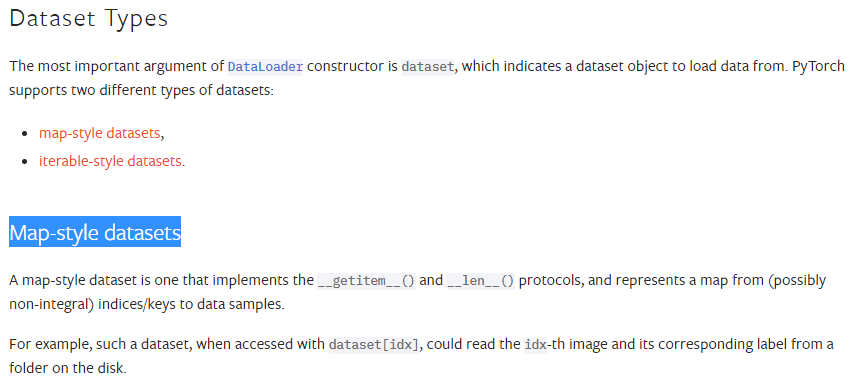

Reference : pyTorch 공식 홈페이지

In [41]:
class Dataset(Dataset):

  def __init__(self):

    self.pairs = json.load(open('pairs_encoded.json'))
    self.dataset_size = len(self.pairs)

  def __getitem__(self, i):

    question = torch.LongTensor(self.pairs[i][0])
    reply =  torch.LongTensor(self.pairs[i][1])

    return question, reply
  
  def __len__(self):
    return self.dataset_size

In [42]:
train_loader = torch.utils.data.DataLoader(Dataset(),
                                           batch_size = 100,
                                           shuffle=True,
                                           pin_memory=True)

In [43]:
question, reply = next(iter(train_loader))

In [44]:
question

tensor([[  20, 1587,  111,  ...,    0,    0,    0],
        [  28,  379,   60,  ...,    0,    0,    0],
        [2393,  341,   36,  ...,    0,    0,    0],
        ...,
        [  20,  143,  278,  ...,    0,    0,    0],
        [  20,  390, 1650,  ...,    0,    0,    0],
        [5567,    9,   28,  ...,    0,    0,    0]])

In [45]:
reply

tensor([[18241,    20,  3082,  ...,     0,     0,     0],
        [18241,    57,  1508,  ...,     0,     0,     0],
        [18241,   246,   157,  ...,   125,  5300, 18242],
        ...,
        [18241,   347,   453,  ...,     0,     0,     0],
        [18241,    36,   510,  ...,     0,     0,     0],
        [18241,    20,   212,  ...,     0,     0,     0]])

In [46]:
print(reply.size())

torch.Size([100, 27])


In [50]:
print(reply[:,:-1].size()) # reply_input
print(reply[:,1:].size()) # reply_target

torch.Size([100, 26])
torch.Size([100, 26])


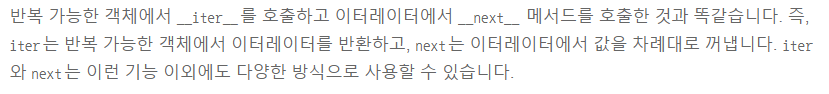

# Transformer Model

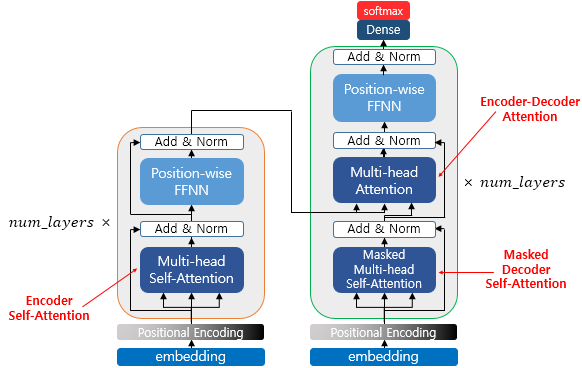

# I. Masking (for Masked Multi-Head Attention in Decoder)

**디코더(Decoder)에서의 Self-Attention Layer 는 반드시 자기 자신 보다 앞쪽에 포지션에 해당하는 토큰들의 어텐션 스코어만 볼수있다. 아웃풋들이 주어졌을 때 뒤에 나오는 단어들은 볼 수 없다.**

**Decoder 부분에서는 현재 내가 알고있는 정보까지만 self-Attention이 가능하다.**

참고 : https://acdongpgm.tistory.com/221

### 전처리 자세한 과정과 반환값(질문있음)

torch.triu : 

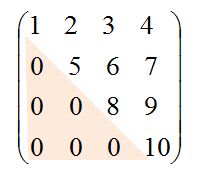

In [112]:
mask = torch.triu(torch.ones(4,4)).transpose(0,1).type(dtype=torch.uint8)
print(mask)

tensor([[1, 0, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 1]], dtype=torch.uint8)


In [114]:
mask.unsqueeze(0)

tensor([[[1, 0, 0, 0],
         [1, 1, 0, 0],
         [1, 1, 1, 0],
         [1, 1, 1, 1]]], dtype=torch.uint8)

In [133]:
mask.size() # unsqueeze(0)하면, 첫번째 차원에 1인 차원을 추가해줌!

torch.Size([4, 4])

In [116]:
0 != 0

False

In [122]:
question[0]

tensor([ 374,  200,   70,   54,  374,  539,  515,  439,   10,   54,  553,   11,
        7179, 1265,  173,  244,  858,  125,    0,    0,    0,    0,    0,    0,
           0])

In [126]:
question[0] != 0

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False, False,
        False, False, False, False, False])

In [131]:
ex = question[0] != 0
ex_unsqz2 = ex.unsqueeze(1).unsqueeze(1)
print(ex_unsqz2) # question_mask 에 해당하는 부분임
print(ex_unsqz2.size()) 

tensor([[[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[ True]],

        [[False]],

        [[False]],

        [[False]],

        [[False]],

        [[False]],

        [[False]],

        [[False]]])
torch.Size([25, 1, 1])


 여기서 부턴 reply

In [138]:
ex_rpl = reply[0] != 0
ex_rpl_unsqz = ex_rpl.unsqueeze(1)
print(ex_rpl)
print(ex_rpl_unsqz)
print(ex_rpl.size())
print(ex_rpl_unsqz.size())

tensor([ True,  True,  True,  True,  True,  True,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False])
tensor([[ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False]])
torch.Size([27])
torch.Size([27, 1])


⭐ 밑에 부분이 잘 이해가 안되서 직접 돌려봄
(27,1) (1,27,27) 1,0으로 이루어진 하삼각행렬

In [151]:
masked_attention = ex_rpl_unsqz & torch.triu(torch.ones(27,27)).transpose(0, 1).type(dtype=torch.uint8).unsqueeze(0).type_as(ex_rpl_unsqz.data)
print(masked_attention)
print(masked_attention.size()) # &는 비트와이즈 연산자. 공통이면 1 겹치지 않으면 0

tensor([[[ True, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False,
          False, False, False, False, Fa

In [152]:
masked_attention.unsqueeze(1).size()

torch.Size([1, 1, 27, 27])

### 다시 돌아와서

In [64]:
def create_masks(question, reply_input, reply_target):

  def subsequent_mask(size):
    mask = torch.triu(torch.ones(size,size)).transpose(0,1).type(dtype=torch.uint8)
    return mask.unsqueeze(0)
  
  question_mask = question !=0  # 단어에 해당하는 부분을 1로 만들어줌.
  question_mask = question_mask.to(device)
  question_mask = question_mask.unsqueeze(1).unsqueeze(1) # (batch_size, 1, 1, max_words)

  reply_input_mask = reply_input != 0
  reply_input_mask = reply_input_mask.unsqueeze(1) # (batch_size, 1, max_words)
  reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data) # 이게 우리가 원하는 mask 행렬임
  reply_target_mask = reply_target != 0

  return question_mask, reply_input_mask, reply_target_mask

Question, Reply, 예측해야할 Reply에 대한 Masking 행렬을 만들어줌 (1,0 으로 이루어진)

# II. Positional Embedding


[기존 RNN 장점]

원래 RNN 처럼 time step 이 중요한 모델에서는

- I am ugly. I do not have girlfriend.

- I am no ugly. I have girlfriend.

위 두 문장의 시간적 데이터를 고려할 수 있었으나






-




[Transformer 모델의 한계]




Transformer는 sequence를 Encoder, Decoder에 넣는 input 형태를 취하다 보니,



이러한 **병렬적 처리에 기인한 시간적 데이터의 손실**이 일어난다.




-


[해결 방법]



이러한 시간적 데이터를 고려해주고자,

Positional Embedding 이라는 기법을 쓴다.






---



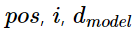

pos : position. input에서 임베딩 벡터의 위치

i : 임베딩 벡터 내 차원의 인덱스

d_model : Encoder, Decoder 에 들어가는 벡터의 차원 **(max_len 아님)**

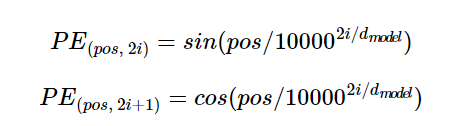

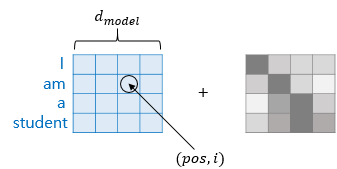

위와 같은 포지셔널 인코딩 방법을 사용하면 순서 정보가 보존됩니다.

예를 들어, 각 임베딩 벡터에 포지셔널 인코딩값을 더하면 같은 단어라고 하더라도 문장 내의 위치에 따라 임베딩 벡터의 값이 달라집니다.

(위 회색 그림을 자세히 보면,

1번째인 I 가 1번째가 까맣게

2번째인 am 이 2번째가 까맣게

3,4 번째인 a studnet 가 3번째가 까맣게 칠해져있음)

❓ (질문) : 사인, 코사인 함수를 사용한 이유?

In [65]:
class Embeddings(nn.Module):
  """
  Implements embeddings of the words and adds their positional encodings.
  """
  def __init__(self, vocab_size, d_model, max_len=50):
    super(Embeddings, self).__init__()
    self.d_model = d_model
    self.dropout = nn.Dropout(0.1)
    self.embed = nn.Embedding(vocab_size, d_model) # nn.Embedding은 random 초기값을 설정하고 weight를 통해 학습하는 과정임.
    self.pe = self.create_positional_encoding(max_len, self.d_model)
    self.dropout = nn.Dropout(0.1) # 질문: dropout 왜 두번씀?
  
  def create_positional_encoding(self, max_len, d_model):
    pe = torch.zeros(max_len, d_model).to(device) 
    for pos in range(max_len): # for each postition of word
      for i in range(0, d_model, 2): # for each dimension of the each position
        pe[pos, i] = math.sin(pos/(10000**((2*i)/d_model)))
        pe[pos, i+1] = math.cos(pos/(10000**((2*(i+1))/d_model)))
    pe = pe.unsqueeze(0) # include the batch size: prepare job
    return pe # (1, max_len, d_model)
  
  def forward(self, encoded_words):
    embedding = self.embed(encoded_words) * math.sqrt(self.d_model)
    embedding += self.pe[:,:embedding.size(1)] # until d_model : pe will automatically be expanded with the same batch size as encoded words
    embedding = self.dropout(embedding)
    return embedding


❓ (질문) : `def forward`에서 왜 `math.sqrt(self.d_model)` 곱하는지?

❓ (질문) : 마지막 forward문에서 차원이 잘 이해가 안됨. 어떻게 학습하는지?

참고자료 : https://velog.io/@cha-suyeon/%ED%8A%B8%EB%9E%9C%EC%8A%A4%ED%8F%AC%EB%A8%B8%EC%9D%98-%EC%9E%85%EB%A0%A5-%EC%9D%B4%ED%95%B4

# III. Multi-Head / Self Attention

여러 헤드가 독자적으로 셀프 어텐션을 계산한다.

⭐ **random initial state가 다르다는 것에 기인하여**, 셀프 어텐션 수행시 각기 다른 연관성을 도출해 낼수 있음. 하나의 헤드가 확인하지 못한 연관성을 다른 헤드에서 확인할 수 있는 것임.

⭐ **Self Attention의 Concept**

> 셀프 어텐션은 쿼리(query), 키(key), 밸류(value) 3개 요소 사이의 문맥적 관계성을 추출하는 과정입니다.

⭐ Decoder에서 Masking하는데 역삼각행렬 꼴로 (아래 흰색이 masked된 부분) 마스킹을 하게 되었을 시에, **문장의 뒤로 갈수록 나오는 미래의 단어(row-wise)들은 이미 Labeled된 단어들이 아니라, 서로 다른 row들이 저렇게만 주어졌을때 (I love him ____ ____.), Encoder에서 "소스"로 학습한 Key, Value를 가지고 Decoder의 Query가 주어졌을때, "주어진 self attention으로부터 도출된 단어간 연관성을 가지고 어떤 sequence를 예측할 것인가?" 가 주어진 TASK이다.**

⭐ 이때 소스, 타깃 각각의 attention 연관성은 어디서 계산(학습) 되느냐?

(학습. 이랑 attention score 계산하는 거랑은 개념적으로는 다른 것 아닐까?)

(학습이 되면서 attention score가 바뀌는 것 같은데 )

> 소스 : Encoder내 Multi-head Attention Block 에서. 

> 타깃 : Decoder내 Masked Multi-head Attention Block 에서.

> 그렇게 한뒤, Encoder의 Key, Value와 Decoder의 Query를 가져왔을때, 앞에서 계산된 Attention Score Vector를 기반으로, 해당 block 의 Attention Score을 계산한다.

지속해서  학습시 영어로 "Cafe"에 해당하는 한국어가 "카페" 인 확률이 가장 높게 올 것이다.

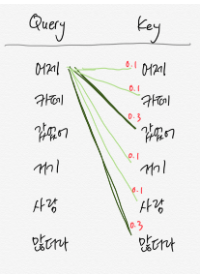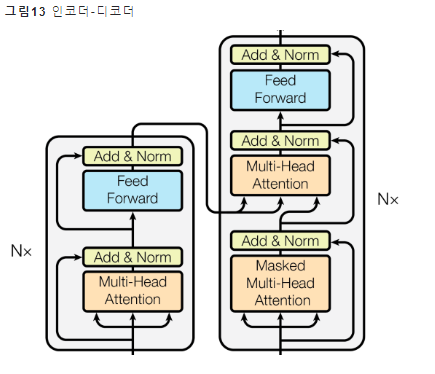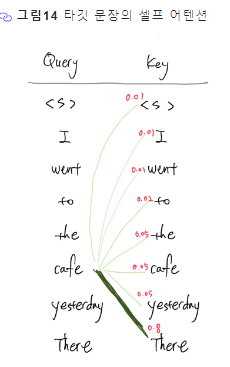

https://ratsgo.github.io/nlpbook/docs/language_model/tr_self_attention/

⭐ 이 글 보고 정말 많이 배웠는데 두고두고 꼭 다시 읽어볼것

❓ (질문) 그렇다면 트랜스포머 모델은 labeled 된 데이터를 가지고 학습하는건가? 트랜스포머 모델은 어떻게 학습하는가? 블락별로 학습하는가? 아니면 Decoder의 Multi-head attention에서 학습하는가?

d_model : 임베딩 벡터의 차원

In [8]:
class MultiHeadAttention(nn.Module):
  
  def __init__(self, heads, d_model):
    
    super(MultiHeadAttention, self).__init__()
    assert d_model % heads == 0 # 나머지 # assert : 주장하다. 그렇다고 하다. # error 방지하기 위해
    self.d_k = d_model // heads # 몫
    self.heads = heads
    self.dropout = nn.Dropout(0.1)
    self.query = nn.Linear(d_model, d_model)
    self.key = nn.Linear(d_model, d_model)
    self.value = nn.Linear(d_model, d_model)
    self.concat = nn.Linear(d_model, d_model)

  def forward(self, query, key, value, mask):
    """
    (query, key, value) shape : (batch_size, max_len, 512)
    (mask) shape : (batch_size, 1, 1, max_words)
    """ # shape 에 대해서는 다시

    # (batch_size, max_len, 512)
    # (질문) 애초에 여기 들어오는 vector들이 이럴것이다! 라고 생각한다는 건가. 그럴것으로 기대한다는 건가.
    query = self.query(query)
    key = self.key(key)
    value = self.value(value)

    # (질문) : 여기 차원 관련해서 이게 어떻게 아래에 나오는 차원으로 변환되는 건지 이해가 안됨.
    # (batch_size, max_len, 512) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
    query = query.view(query.shape[0], -1, self.heads, self.d_k).permute(0,2,1,3) # permute : 차원 순서 바꾸기
    key = key.view(key.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3)  
    value = value.view(value.shape[0], -1, self.heads, self.d_k).permute(0, 2, 1, 3) 

    # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
    scores = torch.matmul(query, key.permute(0,1,3,2)) / math.sqrt(query.size(-1)) # d_k
    scores = scores.masked_fill(mask == 0, -1e9) # masked된것에 대해, -1e9로 바꿔주어, softmax했을때 0에 수렴하게 하겠다. # (batch_size, h, max_len, max_len)
    weights = F.softmax(scores, dim = -1) # (batch_size, h, max_len, max_len)
    weights = self.dropout(weights)

    # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k) 
    context = torch.matmul(weights, value)
    # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, h * d_k)
    context = context.permute(0,2,1,3).contiguous().view(context.shape[0], -1, self.heads * self.d_k)
    # (batch_size, max_len, h * d_k)
    interacted = self.concat(context) # concat and project linear layer
    return interacted

In [6]:
a = torch.randn(4,3)

In [7]:
a.size(-1)

3

# IV. Position-wise Feed-Forward Network

position-wise라는 말이 붙는 이유는, 상위 sequence(문장)이 아닌 각 단어들에 대하여 FFN이 수행된다고 하여 position-wise임.

In [9]:
class FeedForward(nn.Module):

  def __init__(self, d_model, middle_dim=2048):
    super(FeedForward, self).__init__()

    self.fc1 = nn.Linear(d_model, middle_dim)
    self.fc2 = nn.Linear(middle_dim, d_model)
    self.dropout = nn.Dropout(0.1)

  def forward(self,x):
    out = F.relu(self.fc1(x))
    out = self.fc2(self.dropout(out))
    return out

# V. Encoder/Decoder Layer

- Add : 잔차연결 (기울기 소실 문제 해결)

- Layer Norm : 층 정규화. sample에 대하여 정규화하여 학습을 원활하게 해줌.

In [10]:
class EncoderLayer(nn.Module):

  def __init__(self, d_model, heads):
    super(EncoderLayer, self).__init__()
    self.layernorm = nn.LayerNorm(d_model)
    self.self_multihead = MultiHeadAttention(heads, d_model)
    self.feed_forward = FeedForward(d_model)
    self.dropout = nn.Dropout(0.1)

  def forward(self, embeddings, mask):
    interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask)) # query, key, value, mask
    interacted = self.layernorm(interacted + embeddings) # Add & Norm 이렇게 구현됨.
    feed_forward_out = self.dropout(self.feed_forward(interacted))
    encoded = self.layernorm(feed_forward_out + interacted)
    return encoded

In [11]:
class DecoderLayer(nn.Module):

  def __init__(self, d_model, heads):
    super(DecoderLayer, self).__init__()
    self.layernorm = nn.LayerNorm(d_model)
    self.self_multihead = MultiHeadAttention(heads, d_model)
    self.src_multihead = MultiHeadAttention(heads, d_model) # Source Multi Head Attention
    self.feed_forward = FeedForward(d_model)
    self.dropout = nn.Dropout(0.1)

  def forward(self, embeddings, encoded, src_mask, target_mask):
    query = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, target_mask))
    query = self.layernorm(query + embeddings)
    interacted = self.dropout(self.src_multihead(query, encoded, encoded, src_mask)) # source mask가 왜 필요?
    interacted = self.layernorm(interacted + query)
    feed_forward_out = self.dropout(self.feed_forward(interacted))
    decoded = self.layernorm(feed_forward_out + interacted)
    return decoded

In [56]:
class Transformer(nn.Module):

  def __init__(self, d_model, heads, num_layers, word_map):
    super(Transformer, self).__init__()

    self.d_model = d_model
    self.vocab_size = len(word_map)
    self.embed = nn.Embedding(self.vocab_size, d_model)
    self.encoder = nn.ModuleList([EncoderLayer(d_model, heads) for _ in range(num_layers)])
    self.decoder = nn.ModuleList([DecoderLayer(d_model, heads) for _ in range(num_layers)])
    self.logit = nn.Linear(d_model, self.vocab_size) # (질문) logit이 이렇게 단순하게 구현된다고? (대답) 아 뒤에서 log_softmax 씌워서 결과 내줬구나.

  def encode(self, src_words, src_mask):
    src_embeddings = self.embed(src_words)
    for layer in self.encoder:
      src_embeddings = layer(src_embeddings, src_mask) # encoder 내부의 layer들을 통과하라
    return src_embeddings

  def decode(self, target_words, target_mask, src_embeddings, src_mask):
    tgt_embeddings = self.embed(target_words)
    for layer in self.decoder:
      tgt_embeddings = layer(tgt_embeddings, src_embeddings, src_mask, target_mask)
    return tgt_embeddings
  
  def forward(self, src_words, src_mask, target_words, target_mask):
    encoded = self.encode(src_words, src_mask)
    decoded = self.decode(target_words, target_mask, encoded, src_mask)
    out = F.log_softmax(self.logit(decoded),dim=2) # 3번째 차원에 대해서 softmax를 적용시켜 줄거임 # 3번째 차원은 vocab_size 임.(단어 인덱스) # 즉 단어를 예측한다는 말임.
    return out

# VI. LOSS/Optimizer for train SETUP

AdamW 이란?

LossWithLS 이란?

confidence 와 smooth 란?

쿨백-라이뷸러 다이버전스 란?

In [58]:
class AdamWarmup:
    
    def __init__(self, model_size, warmup_steps, optimizer):
        
        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0
        
    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))
        
    def step(self):
        # Increment the number of steps each time we call the step function
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        # update the learning rate
        self.lr = lr
        self.optimizer.step()       

In [59]:
class LossWithLS(nn.Module):

    def __init__(self, size, smooth):
        super(LossWithLS, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False, reduce=False)
        self.confidence = 1.0 - smooth
        self.smooth = smooth
        self.size = size
        
    def forward(self, prediction, target, mask):
        """
        prediction of shape: (batch_size, max_words, vocab_size)
        target and mask of shape: (batch_size, max_words)
        """
        prediction = prediction.view(-1, prediction.size(-1))   # (batch_size * max_words, vocab_size)
        target = target.contiguous().view(-1)   # (batch_size * max_words)
        mask = mask.float()
        mask = mask.view(-1)       # (batch_size * max_words)
        labels = prediction.data.clone()
        labels.fill_(self.smooth / (self.size - 1))
        labels.scatter_(1, target.data.unsqueeze(1), self.confidence)
        loss = self.criterion(prediction, labels)    # (batch_size * max_words, vocab_size)
        loss = (loss.sum(1) * mask).sum() / mask.sum()
        return loss

# VII. Train

In [51]:
print(reply[:,:-1].size()) # reply_input
print(reply[:,1:].size()) # reply_target

torch.Size([100, 26])
torch.Size([100, 26])


위에 코드를 설명하자면,

reply_input은 max_len = 27인 문장에서, 1~26 인덱스의 단어고

reply_output은 2~27 인덱스의 단어다.

1번째가 output으로 나올수 없고, 27번째가 input으로 들어갈 수 없는것은 자명하다.

❓ (질문) Transformer는 어떻게 학습하는가? Label이 따로 있는건가?

In [60]:
# Instantiate Model
d_model = 512
heads = 8
num_layers = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 2 #10

with open('WORDMAP_corpus.json', 'r') as j:
    word_map = json.load(j)
    
transformer = Transformer(d_model = d_model, heads = heads, num_layers = num_layers, word_map = word_map)
transformer = transformer.to(device)
adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = AdamWarmup(model_size = d_model, warmup_steps = 4000, optimizer = adam_optimizer)
criterion = LossWithLS(len(word_map), 0.1)

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [61]:
def train(train_loader, transformer, criterion, epoch):
    
    transformer.train()
    sum_loss = 0
    count = 0

    for i, (question, reply) in enumerate(train_loader):
        
        samples = question.shape[0]

        # Move to device
        question = question.to(device)
        reply = reply.to(device)

        # Prepare Target Data
        reply_input = reply[:, :-1]
        reply_target = reply[:, 1:]

        # Create mask and add dimensions
        question_mask, reply_input_mask, reply_target_mask = create_masks(question, reply_input, reply_target)

        # Get the transformer outputs
        out = transformer(question, question_mask, reply_input, reply_input_mask)

        # Compute the loss
        loss = criterion(out, reply_target, reply_target_mask)
        
        # Backprop
        transformer_optimizer.optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()
        
        sum_loss += loss.item() * samples
        count += samples
        
        if i % 100 == 0:
            print("Epoch [{}][{}/{}]\tLoss: {:.3f}".format(epoch, i, len(train_loader), sum_loss/count))

그리디 디코딩이란?

In [62]:
def evaluate(transformer, question, question_mask, max_len, word_map):
    """
    Performs Greedy Decoding with a batch size of 1
    """
    rev_word_map = {v: k for k, v in word_map.items()}
    transformer.eval()
    start_token = word_map['<start>']
    encoded = transformer.encode(question, question_mask)
    words = torch.LongTensor([[start_token]]).to(device)
    
    for step in range(max_len - 1):
        size = words.shape[1]
        target_mask = torch.triu(torch.ones(size, size)).transpose(0, 1).type(dtype=torch.uint8)
        target_mask = target_mask.to(device).unsqueeze(0).unsqueeze(0)
        decoded = transformer.decode(words, target_mask, encoded, question_mask)
        predictions = transformer.logit(decoded[:, -1])
        _, next_word = torch.max(predictions, dim = 1)
        next_word = next_word.item()
        if next_word == word_map['<end>']:
            break
        words = torch.cat([words, torch.LongTensor([[next_word]]).to(device)], dim = 1)   # (1,step+2)
        
    # Construct Sentence
    if words.dim() == 2:
        words = words.squeeze(0)
        words = words.tolist()
        
    sen_idx = [w for w in words if w not in {word_map['<start>']}]
    sentence = ' '.join([rev_word_map[sen_idx[k]] for k in range(len(sen_idx))])
    
    return sentence

In [66]:
for epoch in range(epochs):
    
    train(train_loader, transformer, criterion, epoch)
    
    state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}
    torch.save(state, 'checkpoint_' + str(epoch) + '.pth.tar')

RuntimeError: ignored

In [ ]:
checkpoint = torch.load('/content/checkpoint_1.pth.tar')
transformer = checkpoint['transformer']

In [ ]:
while(1):
    question = input("Question: ") 
    if question == 'quit':
        break
    max_len = input("Maximum Reply Length: ")
    enc_qus = [word_map.get(word, word_map['<unk>']) for word in question.split()]
    question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)
    question_mask = (question!=0).to(device).unsqueeze(1).unsqueeze(1)  
    sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
    print(sentence)